Nama : Tiara Lailatul Nikmah  
Email : tiaralaila21@gmail.com  
Username : Tiara Laila  
No Telepon : 089635924667  
Asal kota : Juwana, Pati  

In [1]:
# import library
import numpy as np
import pandas as pd
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
import tensorflow as tf

In [2]:
#  ubah dataset menjadi dataframe
data = pd.read_csv('weather_data_kolkata_2015_2020.csv')
data.head()

,DATETIME,TEMPERATURE,HUMIDITY
0,2015-01-01 00:00:00,19.0,75.0
1,2015-01-01 01:00:00,19.0,77.0
2,2015-01-01 02:00:00,19.0,78.0
3,2015-01-01 03:00:00,19.0,80.0
4,2015-01-01 04:00:00,19.0,81.0


In [5]:
data.tail()

,DATETIME,TEMPERATURE,HUMIDITY
52603,2020-12-31 19:00:00,25.0,36.0
52604,2020-12-31 20:00:00,24.0,37.0
52605,2020-12-31 21:00:00,23.0,38.0
52606,2020-12-31 22:00:00,22.0,39.0
52607,2020-12-31 23:00:00,21.0,40.0


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52608 entries, 0 to 52607
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   DATETIME     52608 non-null  object 
 1   TEMPERATURE  52608 non-null  float64
 2   HUMIDITY     52608 non-null  float64
dtypes: float64(2), object(1)
memory usage: 1.2+ MB


In [4]:
data['DATETIME'] = pd.to_datetime(data['DATETIME'])

In [6]:
data.dtypes

DATETIME       datetime64[ns]
TEMPERATURE           float64
HUMIDITY              float64
dtype: object

In [7]:
data['TEMPERATURE'].min()

11.0

In [8]:
data['TEMPERATURE'].max()

45.0

In [9]:
# Mengambil sampel 11000 record data saja
data = data[:11000]

In [10]:
# mengecek apakah ada nilai yang hilang
data.isnull().sum()

DATETIME       0
TEMPERATURE    0
HUMIDITY       0
dtype: int64

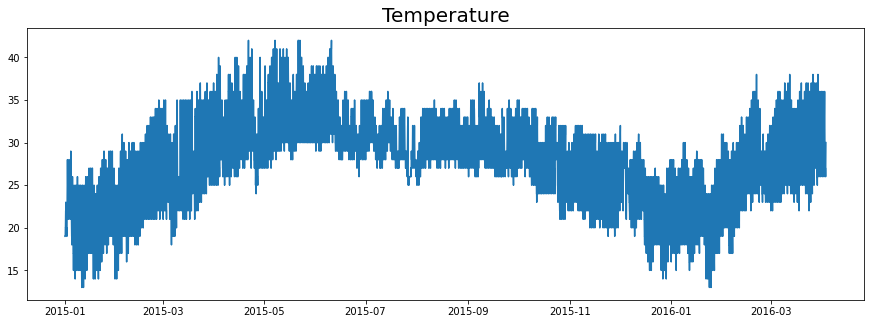

In [11]:
# membuat plot dari data
dates = data['DATETIME'].values
temp  = data['TEMPERATURE'].values
 
 
plt.figure(figsize=(15,5))
plt.plot(dates, temp)
plt.title('Temperature',
          fontsize=20);

In [12]:
# mae sebelum minmaxscaler
maxmae = (data['TEMPERATURE'].max() - data['TEMPERATURE'].min()) * 0.1
maxmae

2.9000000000000004

In [13]:
# normalisasi dataset
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler = scaler.fit(data[['TEMPERATURE']])
data_scaled = scaler.transform(data[['TEMPERATURE']])

In [14]:
# minmaxscaler
from sklearn.preprocessing import MinMaxScaler
minmaxscaler = MinMaxScaler(feature_range = (0,1))
scaled = minmaxscaler.fit_transform(data[['TEMPERATURE']])
data[['TEMPERATURE']] = scaled

In [15]:
# mae sesudah minmaxscaler
maxmae = (data['TEMPERATURE'].max() - data['TEMPERATURE'].min()) * 0.1
maxmae

0.1

In [16]:
data.head()

,DATETIME,TEMPERATURE,HUMIDITY
0,2015-01-01 00:00:00,0.206897,75.0
1,2015-01-01 01:00:00,0.206897,77.0
2,2015-01-01 02:00:00,0.206897,78.0
3,2015-01-01 03:00:00,0.206897,80.0
4,2015-01-01 04:00:00,0.206897,81.0


In [18]:
data.tail()

,DATETIME,TEMPERATURE,HUMIDITY
10995,2016-04-03 03:00:00,0.448276,89.0
10996,2016-04-03 04:00:00,0.482759,84.0
10997,2016-04-03 05:00:00,0.517241,79.0
10998,2016-04-03 06:00:00,0.551724,75.0
10999,2016-04-03 07:00:00,0.586207,71.0


In [19]:
# bagi data untuk training dan data untuk testing
# validation set sebesar 20% dari total dataset
from sklearn.model_selection import train_test_split
temp_latih, temp_test, dates_latih, dates_test = train_test_split(temp, dates, test_size=0.2, random_state = 0 , shuffle=False)
print(len(temp_latih), len(temp_test))

8800 2200


In [20]:
# merubah data menjadi format yang dapat diterima oleh model
# sebuah series/atribut yang telah di konversi menjadi tipe numpy
# mengembalikan label dan atribut dari dataset dalam bentuk batch
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[-1:]))
    return ds.batch(batch_size).prefetch(1)

In [21]:
# membuat arsitektur model
# menggunakan 2 buah layer LSTM yang memiliki parameter return_sequences yang bernilai True
train_set = windowed_dataset(temp_latih, window_size=256, batch_size=1024, shuffle_buffer=2000)
validation_set = windowed_dataset(temp_test, window_size=256, batch_size=1024, shuffle_buffer=2000)
model = tf.keras.models.Sequential([    
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True)),    
  tf.keras.layers.MaxPooling1D(),      
  tf.keras.layers.Dropout(0.2),                
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.LSTM(64), 
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(20, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 100)
])

In [22]:
# fungsi callback untuk menghentikan epoch apabila mae sudah mencapai kurang dari 10%
class toCallback(tf.keras.callbacks.Callback): 
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('mae')<0.1):
      print("Proses Training Berhenti, Tingkat Mae Sudah Kurang Dari 10%")
      self.model.stop_training = True

callbacks= toCallback()

In [23]:
lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-8 * 10**(epoch / 20))
#  pada optimizer menggunakan parameter learning rate dan momentum
optimizer = tf.keras.optimizers.SGD(lr=1.0000e-04, momentum=0.9)
#  loss function Huber yang umum digunakan pada kasus time series
#  metrik yang digunakan untuk mengevaluasi model adalah MAE
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
tf.keras.backend.set_floatx('float64')
latih = model.fit(train_set, batch_size=1024, epochs=400, validation_data=validation_set, verbose=2, callbacks=[callbacks])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/400
9/9 - 106s - loss: 0.3354 - mae: 0.7513 - val_loss: 0.2746 - val_mae: 0.7087
Epoch 2/400
9/9 - 91s - loss: 0.1165 - mae: 0.4228 - val_loss: 0.0572 - val_mae: 0.3059
Epoch 3/400
9/9 - 93s - loss: 0.0434 - mae: 0.2574 - val_loss: 0.0128 - val_mae: 0.1368
Epoch 4/400
9/9 - 92s - loss: 0.0195 - mae: 0.1619 - val_loss: 0.0209 - val_mae: 0.1752
Epoch 5/400
9/9 - 93s - loss: 0.0132 - mae: 0.1313 - val_loss: 0.0117 - val_mae: 0.1323
Epoch 6/400
9/9 - 94s - loss: 0.0099 - mae: 0.1137 - val_loss: 0.0075 - val_mae: 0.1051
Epoch 7/400
9/9 - 94s - loss: 0.0092 - mae: 0.1097 - val_loss: 0.0090 - val_mae: 0.1061
Epoch 8/400
9/9 - 93s - loss: 0.0089 - mae: 0.1075 - val_loss: 0.0083 - val_mae: 0.1036
Epoch 9/400
9/9 - 93s - loss: 0.0082 - mae: 0.1038 - val_loss: 0.0078 - val_mae: 0.1026
Epoch 10/400
9/9 - 92s - loss: 0.0084 - mae: 0.1054 - val_loss: 0.0075 - val_mae: 0.1061
Epoch 11/400
9/9 - 92s - loss: 0.0082 - mae: 0.1048 - val_loss: 0.0080 - val_mae: 0.1099
Epoch 12/400
9/9 - 92s - loss

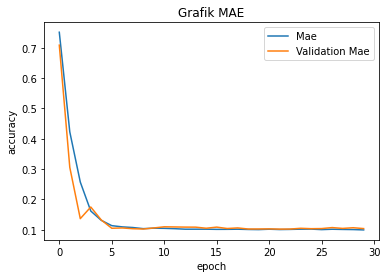

<Figure size 432x288 with 0 Axes>

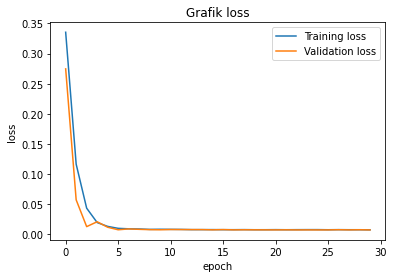

<Figure size 432x288 with 0 Axes>

In [24]:
# membuat grafik akurasi data training dan validasi
import matplotlib.pyplot as plt

mae = latih.history['mae']
val_mae = latih.history['val_mae']
loss = latih.history['loss']
val_loss = latih.history['val_loss']

epoch_range = range(len(mae))

plt.plot(epoch_range, mae, label='Mae')
plt.plot(epoch_range, val_mae, label='Validation Mae')
plt.title('Grafik MAE')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(loc=0)
plt.figure()
plt.show()

plt.plot(epoch_range, loss, label='Training loss')
plt.plot(epoch_range, val_loss, label='Validation loss')
plt.title('Grafik loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(loc=0)
plt.figure()
plt.show()